In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

import quantpy.quantpy as qp
from quantpy.quantpy.routines import _left_inv
from quantpy.quantpy.stats import l2_mean, l2_variance

%matplotlib inline

In [46]:
class HolderTomograph(qp.ProcessTomograph):
    def holder(self, n_points, interval='gamma', method='lin', method_boot='lin',
               physical=True, init='lin', tol=1e-3, max_iter=100, step=0.01, burn_steps=1000, thinning=1):
        if interval == 'gamma':
            state_deltas = np.asarray([tmg.gamma_interval(n_points)[0] for tmg in self.tomographs])
        elif interval == 'mhmc':
            state_deltas = np.asarray([tmg.mhmc(n_points, step, burn_steps, thinning)[0] 
                                       for tmg in self.tomographs])
        elif interval == 'boot':
            state_deltas = np.asarray([
                tmg.bootstrap(n_points, method_boot, physical=physical, init=init, tol=tol, max_iter=max_iter)[0]
                for tmg in self.tomogrpahs
            ])
        else:
            raise ValueError('Incorrect value for argument `interval`.')
        
        return self.holder_deltas(n_points, state_deltas)
    
    def holder_deltas(self, n_points, state_deltas):        
        coef = np.abs(np.einsum('ij,ik->jk', self._decomposed_single_entries, 
                                             self._decomposed_single_entries.conj()))
        state_deltas_composition = np.einsum('ik,jk->ijk', state_deltas, state_deltas)
        dist = np.sqrt(np.einsum('ijk,ij->k', state_deltas_composition, coef))
        CLs = np.linspace(0, 1, len(dist))
        return dist, CLs, state_deltas, coef

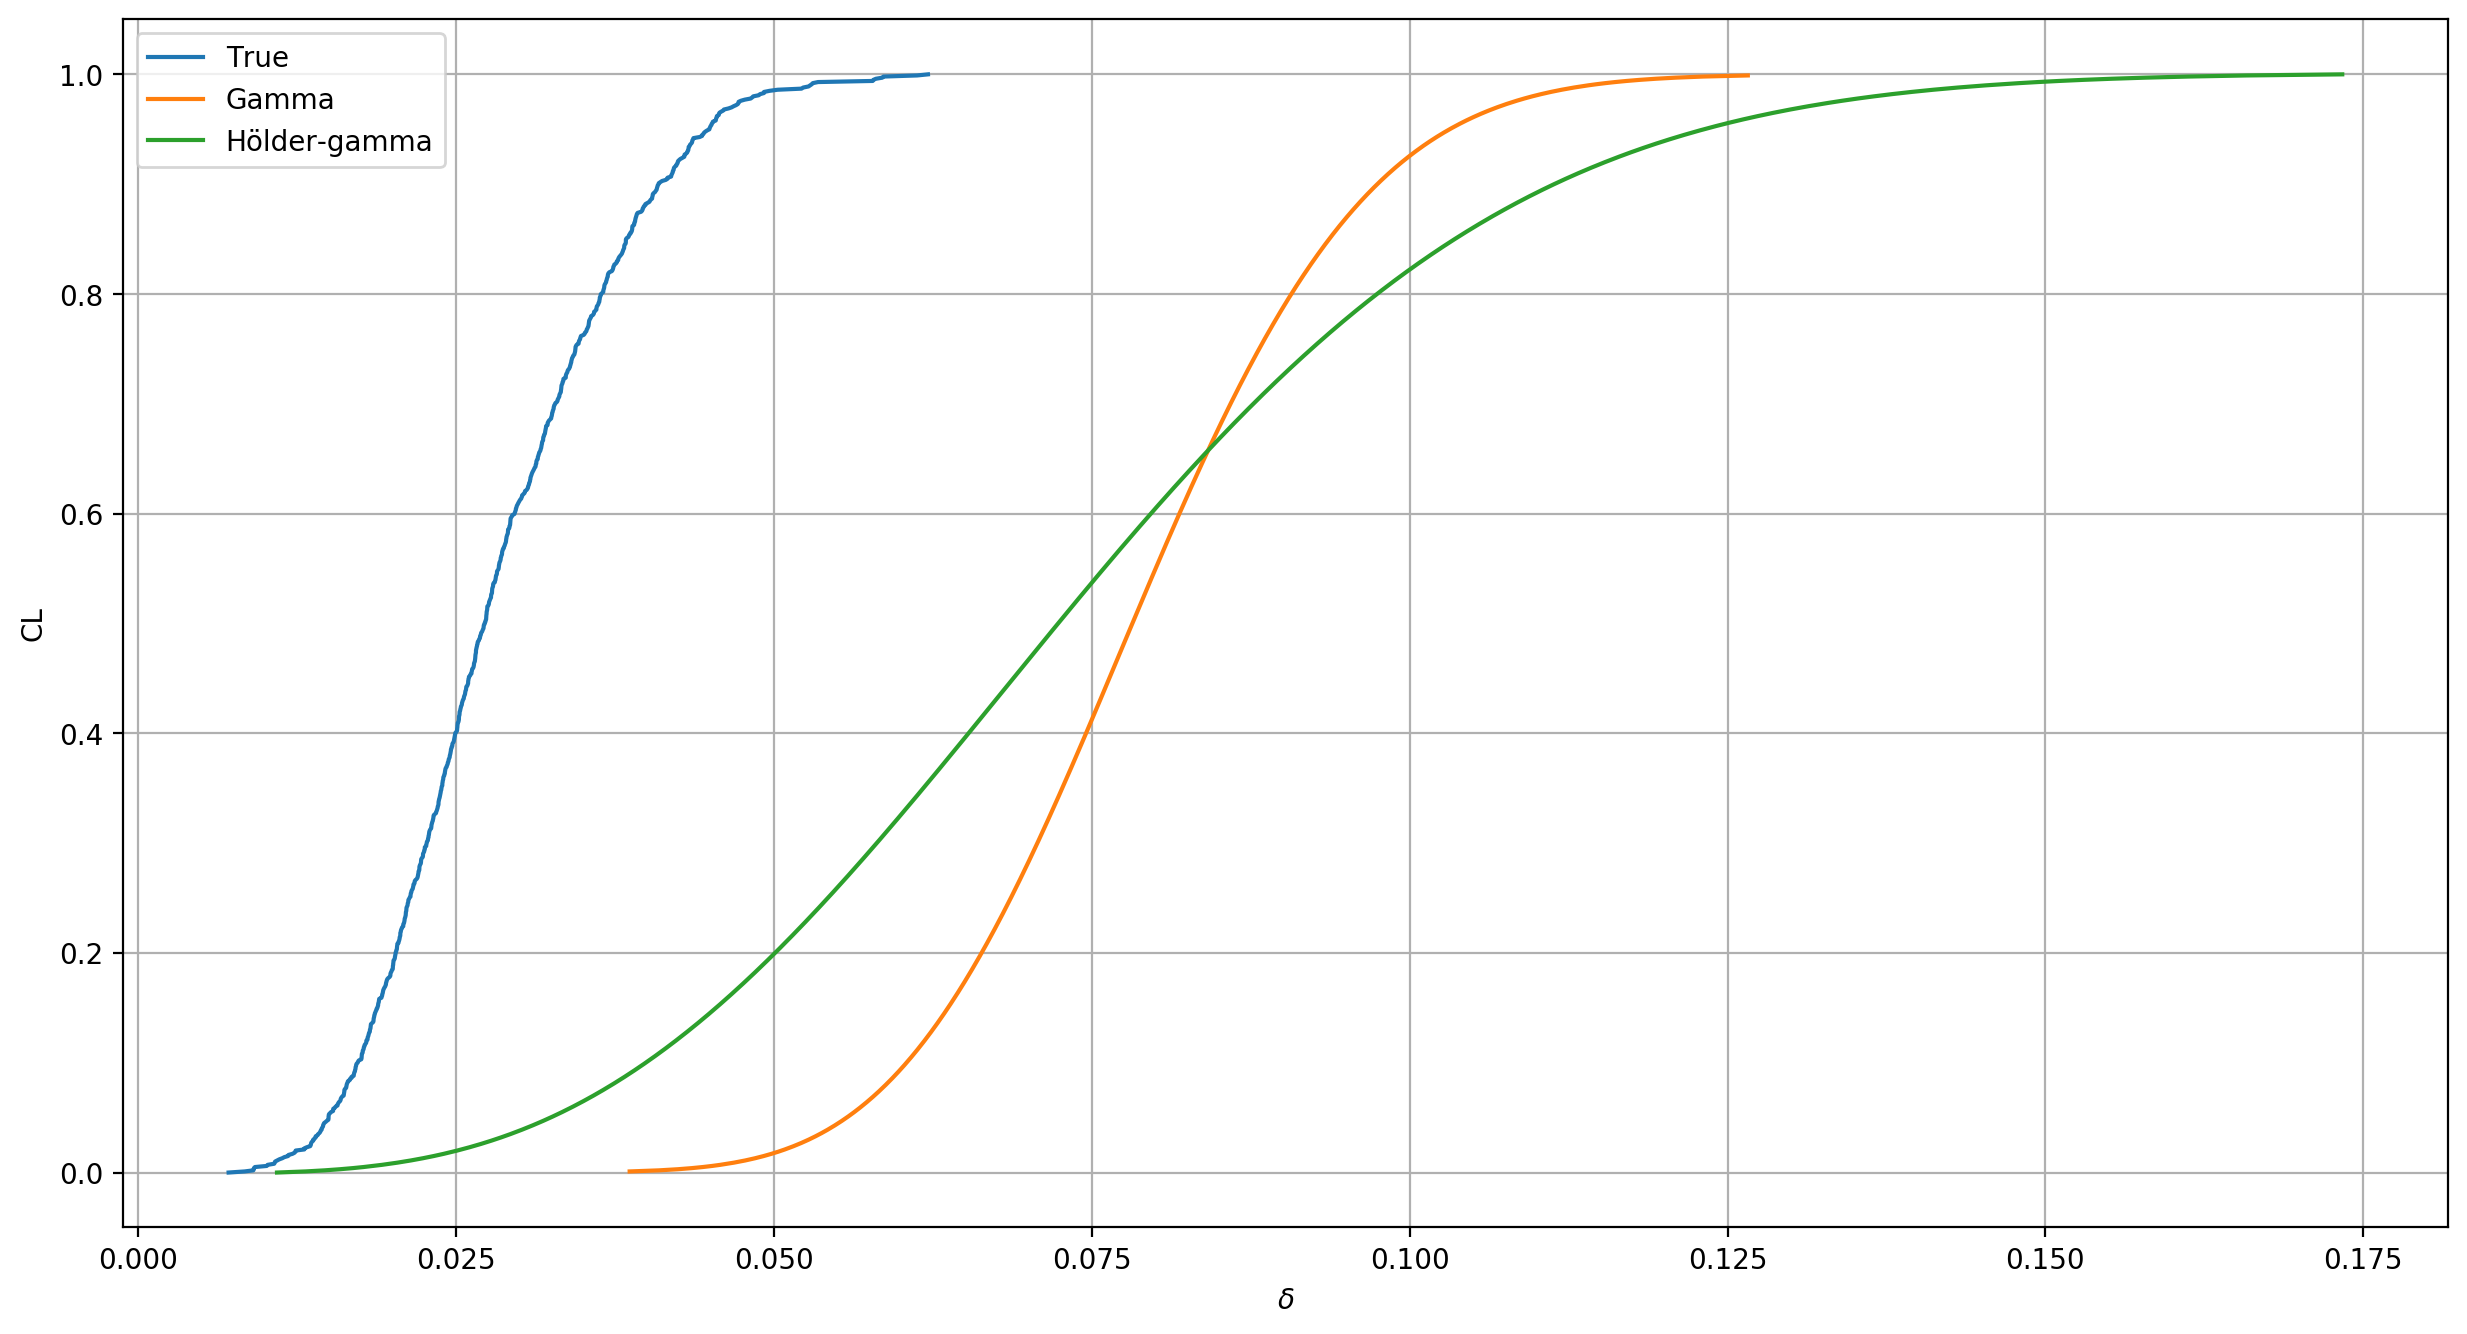

In [51]:
n_measurements = 10000
n_points = 1000
POVM = 'proj'

channel = qp.operator.H.as_channel()
tmg = HolderTomograph(channel)
tmg.experiment(n_measurements, POVM)
state_hat = tmg.point_estimate('lifp')

# state_deltas = []
# for stmg in tmg.tomographs:
#     deltas_true = []
#     for _ in range(n_points):
#         stmg.experiment(n_measurements, POVM)
#         state_hat = stmg.point_estimate('lin')
#         deltas_true.append(qp.hs_dst(state_hat, stmg.state))
#     state_deltas.append(np.array(sorted(deltas_true)))
# state_deltas = np.asarray(state_deltas)

# dist_holder, CLs_holder = tmg.holder_deltas(n_points, state_deltas)
dist_holder_gamma, CLs_holder_gamma, state_deltas, coef_holder = tmg.holder(n_points)
dist_gamma, CLs_gamma = tmg.gamma_interval(n_points)

dist_true = []
for _ in range(n_points):
    tmg.experiment(n_measurements, POVM)
    channel_sample = tmg.point_estimate('lifp')
    dist_true.append(qp.hs_dst(channel_sample.choi, channel.choi))
dist_true = np.array(sorted(dist_true))
CLs_true = np.linspace(0, 1, n_points)

plt.figure(figsize=(15, 8), dpi=200)
plt.grid()
plt.plot(dist_true, CLs_true, label='True')
plt.plot(dist_gamma, CLs_gamma, label='Gamma')
# plt.plot(dist_holder, CLs_holder, label='Hölder')
plt.plot(dist_holder_gamma, CLs_holder_gamma, label='Hölder-gamma')
plt.legend()
plt.xlabel('$\\delta$')
plt.ylabel('CL')
plt.show()

In [17]:
state_deltas

array([[0.00000000e+00, 2.23606781e-04, 2.23606781e-04, ...,
        1.69882294e-02, 1.69999778e-02, 1.80944226e-02],
       [1.41421352e-04, 3.16227719e-04, 3.60555057e-04, ...,
        1.68998551e-02, 1.74668409e-02, 2.01898729e-02],
       [3.16227719e-04, 3.16227719e-04, 4.99999813e-04, ...,
        1.79718327e-02, 1.85680658e-02, 1.86584047e-02],
       [9.99999985e-05, 3.16227719e-04, 3.16227719e-04, ...,
        1.64301924e-02, 1.66138878e-02, 1.86861952e-02]])

In [21]:
state_deltas

array([[0.00022366, 0.0003163 , 0.00038746, ..., 0.01704358, 0.01762805,
        0.01858439],
       [0.00022364, 0.00031628, 0.00038743, ..., 0.01704231, 0.01762674,
        0.01858301],
       [0.00022365, 0.00031629, 0.00038744, ..., 0.01704308, 0.01762753,
        0.01858384],
       [0.00022362, 0.00031624, 0.00038738, ..., 0.01704035, 0.01762471,
        0.01858087]])

In [32]:
coef = np.zeros((4, 4), dtype=np.complex128)
for i in range(4):
    for k in range(4):
        for j in range(4):
            coef[k, j] += tmg._decomposed_single_entries[i, k] * tmg._decomposed_single_entries[i, j].conj()
coef

array([[ 2.00000000e+00+0.j,  7.40148683e-17+0.j, -1.00000000e+00+0.j,
        -1.00000000e+00+0.j],
       [ 7.40148683e-17+0.j,  2.00000000e+00+0.j, -1.00000000e+00+0.j,
        -1.00000000e+00+0.j],
       [-1.00000000e+00+0.j, -1.00000000e+00+0.j,  2.00000000e+00+0.j,
         1.00000000e+00+0.j],
       [-1.00000000e+00+0.j, -1.00000000e+00+0.j,  1.00000000e+00+0.j,
         2.00000000e+00+0.j]])

In [37]:
delta = state_deltas[:, 50]
delta

array([0.00161697, 0.00161674, 0.00161689, 0.00161695])

In [39]:
np.sqrt(delta @ np.abs(coef) @ delta.T)

0.00685988059139438

In [41]:
dist_holder_gamma[50]

0.00685988059139438